In [2]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [3]:
# Define data folder path
data_folder = Path('raw_csv_data')

# Get all CSV files
csv_files = list(data_folder.glob("*.csv"))

print(f"Total CSV files found: {len(csv_files)}\n")
print(csv_files)

Total CSV files found: 27

[WindowsPath('raw_csv_data/Acrylic 1.csv'), WindowsPath('raw_csv_data/Acrylic 2.csv'), WindowsPath('raw_csv_data/Acrylic 3.csv'), WindowsPath('raw_csv_data/Acrylic 3B.csv'), WindowsPath('raw_csv_data/Acrylic 3C.csv'), WindowsPath('raw_csv_data/Cotton - 1.csv'), WindowsPath('raw_csv_data/Cotton - 2.csv'), WindowsPath('raw_csv_data/Cotton - 3.csv'), WindowsPath('raw_csv_data/Cotton - Test 1.csv'), WindowsPath('raw_csv_data/Cotton - Test 2.csv'), WindowsPath('raw_csv_data/Cotton - Test 3.csv'), WindowsPath('raw_csv_data/Linen - 1.csv'), WindowsPath('raw_csv_data/Linen - 2.csv'), WindowsPath('raw_csv_data/Nylon 1.csv'), WindowsPath('raw_csv_data/Nylon 2.csv'), WindowsPath('raw_csv_data/Nylon 3.csv'), WindowsPath('raw_csv_data/Polyester 1.csv'), WindowsPath('raw_csv_data/Polyester 2.csv'), WindowsPath('raw_csv_data/Polyester 3.csv'), WindowsPath('raw_csv_data/Silk - 1.csv'), WindowsPath('raw_csv_data/Silk - Test 1.csv'), WindowsPath('raw_csv_data/Silk - Test 2.csv

In [4]:
# Analyze file structure
fabric_counts = {}
file_info = []

for csv_file in sorted(csv_files):
    # Extract fabric type from filename
    match = re.match(r"([a-zA-Z\s]+)", csv_file.stem)
    fabric_type = match.group(1).strip() if match else "Unknown"
    
    fabric_counts[fabric_type] = fabric_counts.get(fabric_type, 0) + 1
    
    # Read a sample file to get dimensions
    df_sample = pd.read_csv(csv_file, skiprows=1, header=0)
    
    file_info.append({
        'Filename': csv_file.name,
        'Fabric Type': fabric_type,
        'Data Points': len(df_sample)
    })

print(f"-" * 60)
# Display file information
info_df = pd.DataFrame(file_info)
print("\nFile Details:")
print(info_df.to_string(index=False))

# Display fabric type distribution
print(f"\n\nFabric Type Distribution:")
print(f"-" * 60)
for fabric, count in sorted(fabric_counts.items()):
    print(f"  {fabric:<15} : {count} samples")

print(f"\nData inspection complete!")

------------------------------------------------------------

File Details:
           Filename Fabric Type  Data Points
      Acrylic 1.csv     Acrylic         3451
      Acrylic 2.csv     Acrylic         3451
      Acrylic 3.csv     Acrylic         3451
     Acrylic 3B.csv     Acrylic         3451
     Acrylic 3C.csv     Acrylic         3451
     Cotton - 1.csv      Cotton         3451
     Cotton - 2.csv      Cotton         3451
     Cotton - 3.csv      Cotton         3451
Cotton - Test 1.csv      Cotton         3451
Cotton - Test 2.csv      Cotton         3451
Cotton - Test 3.csv      Cotton         3451
      Linen - 1.csv       Linen         3451
      Linen - 2.csv       Linen         3451
        Nylon 1.csv       Nylon         3451
        Nylon 2.csv       Nylon         3451
        Nylon 3.csv       Nylon         3451
    Polyester 1.csv   Polyester         3451
    Polyester 2.csv   Polyester         3451
    Polyester 3.csv   Polyester         3451
       Silk - 1.csv     

Now let's visualise the raw %T (percent transmittance) vs wavenumber data to identify:
- **Baseline shifts**: Vertical offsets between spectra
- **Scattering effects**: Sloping baselines (especially at higher wavenumbers)
- **Peak characteristics**: Functional group absorption bands
- **Spectral variability**: Within-class and between-class differences

Generating Plot 1: Within-Class Variability for Each Fabric Type


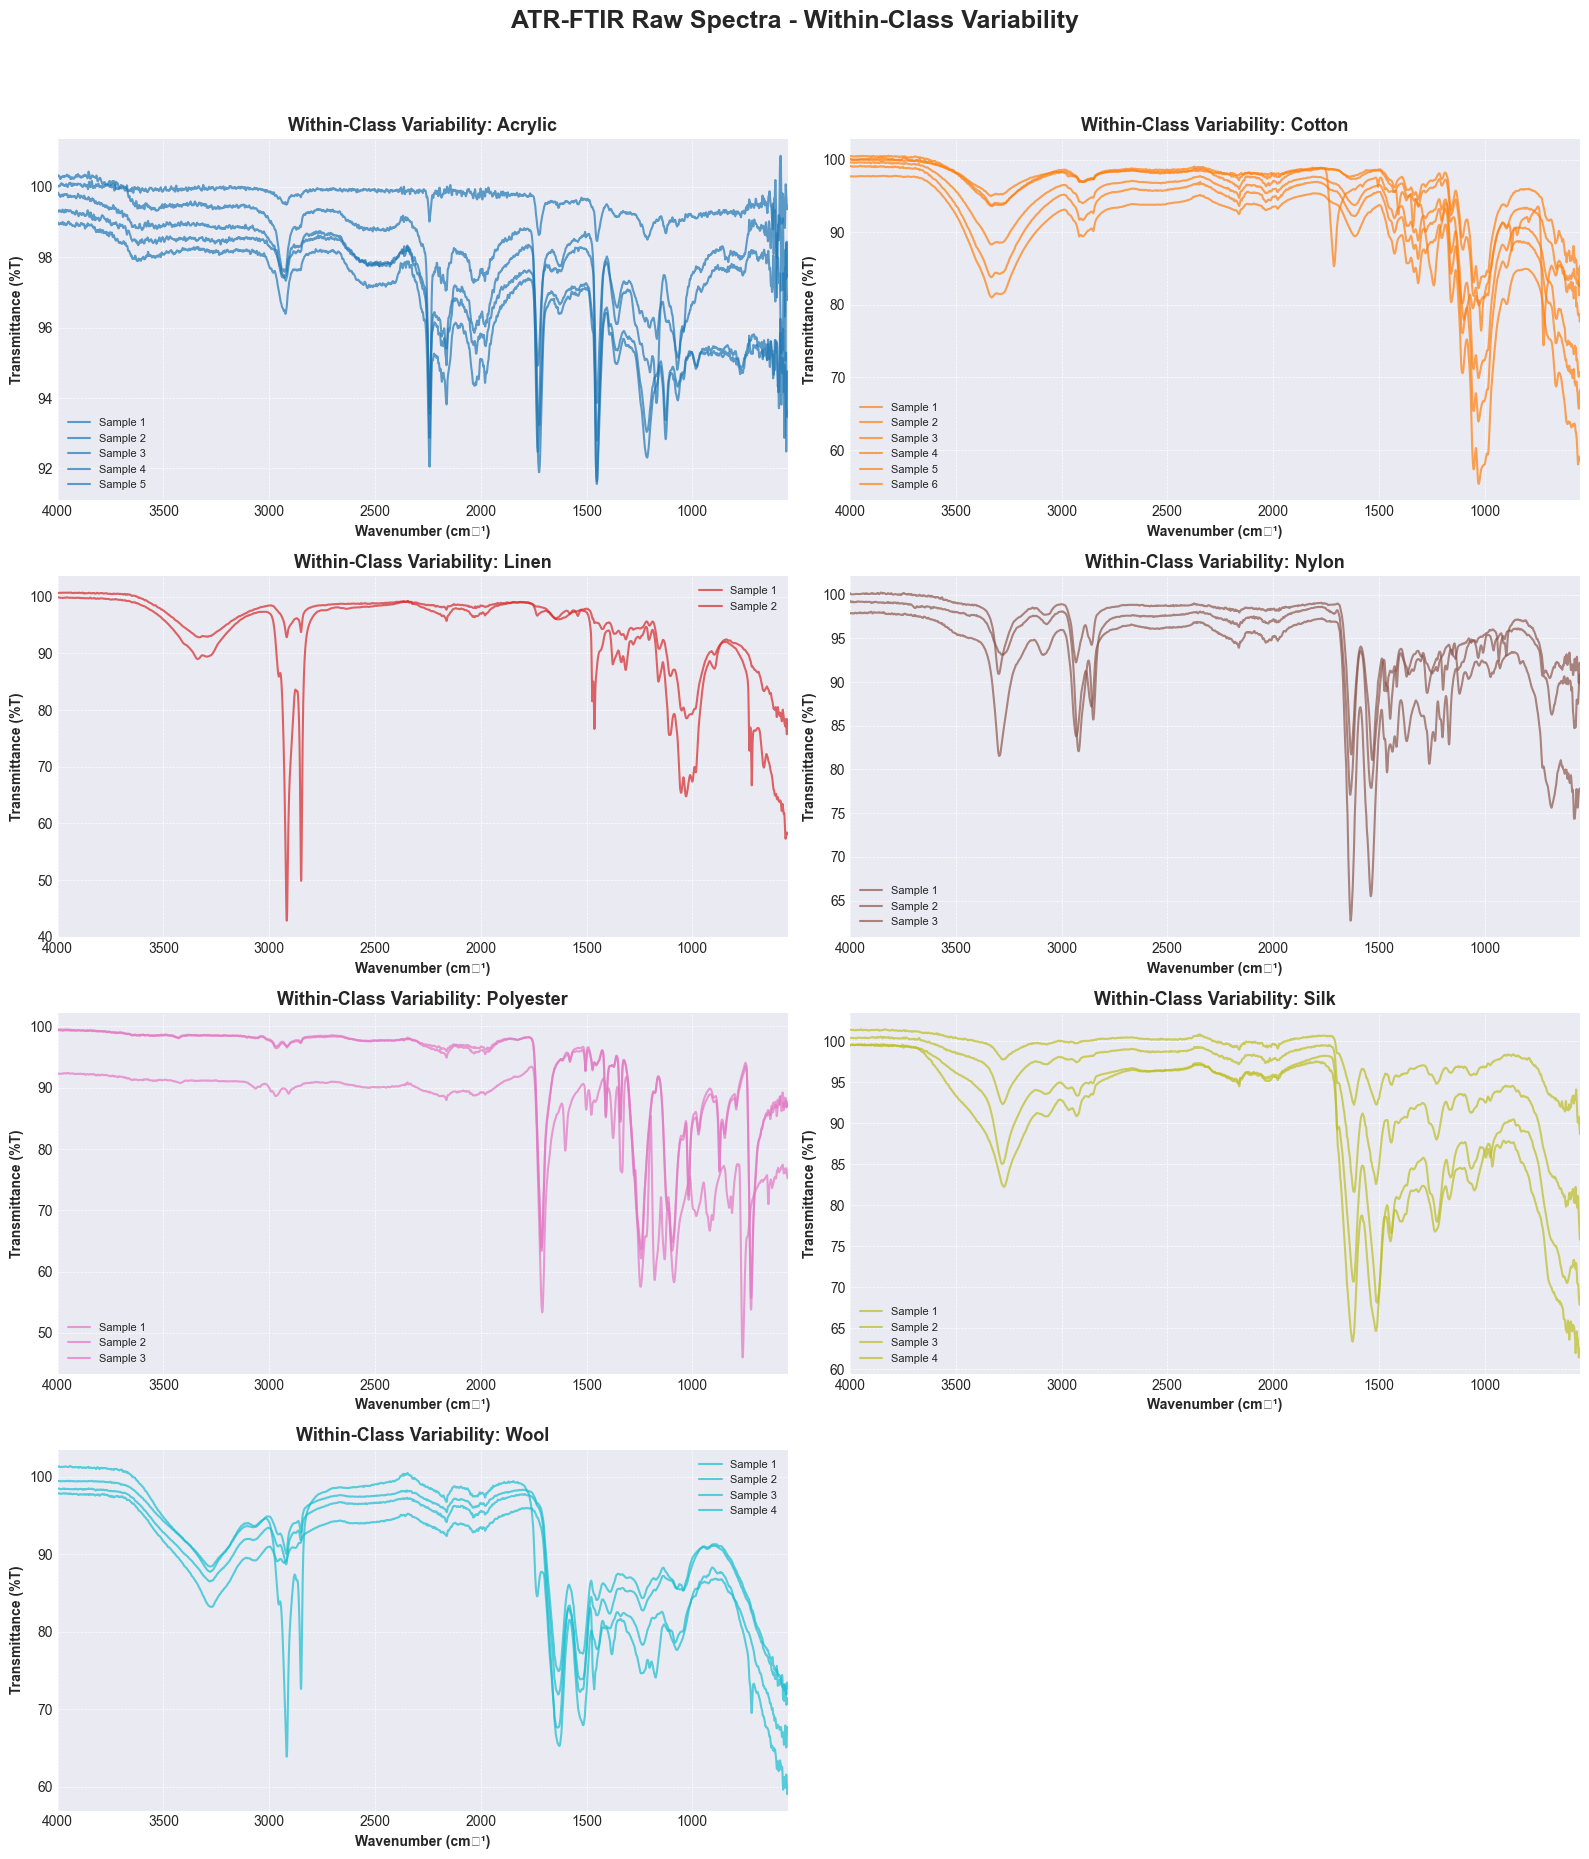

In [5]:
# Load and visualize raw transmittance data
plt.style.use('seaborn-v0_8-darkgrid')

# Within-Class Variability for All Fabric Types
print("Generating Plot 1: Within-Class Variability for Each Fabric Type")

fabric_types = sorted(fabric_counts.keys())
n_fabrics = len(fabric_types)
n_cols = 2
n_rows = (n_fabrics + n_cols - 1) // n_cols  # Calculate rows needed

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4.5), squeeze=False)
axes1 = axes1.flatten()

# Define color palette for fabric types
colors = plt.cm.get_cmap('tab10', n_fabrics)
color_map = dict(zip(fabric_types, [colors(i) for i in range(n_fabrics)]))

for i, fabric in enumerate(fabric_types):
    ax = axes1[i]
    fabric_files = [f for f in csv_files if f.stem.startswith(fabric)]
    
    # Use a consistent color for all samples of the same fabric type
    fabric_color = color_map[fabric]
    
    for j, csv_file in enumerate(fabric_files):
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        ax.plot(df['cm-1'], df['%T'], linewidth=1.5, alpha=0.7, label=f"Sample {j+1}", color=fabric_color)

    ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Transmittance (%T)', fontsize=10, fontweight='bold')
    ax.set_title(f'Within-Class Variability: {fabric}', fontsize=13, fontweight='bold')
    ax.invert_xaxis()
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(4000, 550)

# Hide any unused subplots
for i in range(n_fabrics, len(axes1)):
    fig1.delaxes(axes1[i])

fig1.suptitle('ATR-FTIR Raw Spectra - Within-Class Variability', fontsize=18, fontweight='bold', y=1.03)
fig1.tight_layout()
plt.show()

## Interactive Class-Wise Baseline Shift Visualization

Select a fabric type to visualize baseline shifts and scattering effects within that specific class.

In [6]:
from ipywidgets import interact, Dropdown

def plot_class_baseline_shifts(selected_fabric):
    """
    Plot all samples of a selected fabric type to visualize within-class baseline shifts.
    
    Parameters:
    -----------
    selected_fabric : str
        Fabric type selected from dropdown
    """
    # Get all files for selected fabric type
    fabric_files = [f for f in csv_files if f.stem.startswith(selected_fabric)]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Full spectrum range (4000-550 cm^-1)
    for i, csv_file in enumerate(fabric_files):
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        wavenumbers = df['cm-1'].values
        transmittance = df['%T'].values
        
        ax1.plot(wavenumbers, transmittance, linewidth=1.5, alpha=0.7, 
                label=f'Sample {i+1}', color=color_map[selected_fabric])
    
    ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{selected_fabric} - Baseline Shifts (Full Spectrum)', fontsize=14, fontweight='bold')
    ax1.invert_xaxis()
    ax1.set_xlim(4000, 550)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Plot 2: Fingerprint region (1800-550 cm^-1) for detailed view
    for i, csv_file in enumerate(fabric_files):
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        wavenumbers = df['cm-1'].values
        transmittance = df['%T'].values
        
        ax2.plot(wavenumbers, transmittance, linewidth=1.5, alpha=0.7,
                label=f'Sample {i+1}', color=color_map[selected_fabric])
    
    ax2.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
    ax2.set_title(f'{selected_fabric} - Baseline Shifts (Fingerprint Region)', fontsize=14, fontweight='bold')
    ax2.invert_xaxis()
    ax2.set_xlim(1800, 550)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print baseline statistics
    print("\n" + "="*70)
    print(f"Baseline Analysis: {selected_fabric}")
    print("="*70)
    print(f"\nNumber of samples: {len(fabric_files)}")
    
    # Calculate baseline variations at specific wavenumbers
    baseline_points = [4000, 2000, 1000, 600]  # Key wavenumber positions
    
    print(f"\n{'Wavenumber (cm^-1)':<20} {'Min %T':<15} {'Max %T':<15} {'Range':<15}")
    print("-" * 70)
    
    for wn_target in baseline_points:
        transmittance_values = []
        for csv_file in fabric_files:
            df = pd.read_csv(csv_file, skiprows=1, header=0)
            # Find closest wavenumber
            idx = np.argmin(np.abs(df['cm-1'].values - wn_target))
            transmittance_values.append(df['%T'].values[idx])
        
        min_t = np.min(transmittance_values)
        max_t = np.max(transmittance_values)
        range_t = max_t - min_t
        
        print(f"{wn_target:<20} {min_t:<15.2f} {max_t:<15.2f} {range_t:<15.2f}")
    
    print("="*70)

# Create interactive dropdown widget
interact(plot_class_baseline_shifts,
         selected_fabric=Dropdown(
             options=sorted(fabric_types),
             value=sorted(fabric_types)[0],
             description='Select Fabric:',
             style={'description_width': 'initial'},
             layout={'width': '400px'}
         ))

interactive(children=(Dropdown(description='Select Fabric:', layout=Layout(width='400px'), options=('Acrylic',…

<function __main__.plot_class_baseline_shifts(selected_fabric)>

## Interactive Spectrum Viewer with Peak Identification

Select any sample from the dropdown to visualize its spectrum and identify important peaks.

In [7]:
from scipy.signal import find_peaks
from ipywidgets import interact, Dropdown

# Create dropdown options from available CSV files
csv_options = {f.stem: f for f in sorted(csv_files)}

def plot_spectrum_with_peaks(selected_file):
    """
    Plot the selected spectrum with identified peaks.
    
    Peak identification focuses on major absorption bands:
    - O-H/N-H stretch: 3600-3200 cm⁻¹
    - C-H stretch: 3000-2800 cm⁻¹
    - C=O stretch: 1750-1600 cm⁻¹
    - Fingerprint region: 1500-550 cm⁻¹
    """
    # Load the selected CSV file
    csv_file = csv_options[selected_file]
    df = pd.read_csv(csv_file, skiprows=1, header=0)
    
    wavenumbers = df['cm-1'].values
    transmittance = df['%T'].values
    
    # Convert to absorbance for peak detection
    absorbance = 2 - np.log10(transmittance + 1e-9) # Formula: A = 2 - log10(%T)
    
    # Detect peaks in absorbance (peaks = high absorbance = low transmittance)
    # Parameters tuned for FTIR spectra
    peaks, properties = find_peaks(
        absorbance, 
        prominence=0.005,  # Minimum peak prominence
        distance=10,      # Minimum distance between peaks (in data points)
        height=0.002      # Minimum peak height in absorbance units
    )
    
    # Filter to keep only significant peaks (top 15 by prominence)
    if len(peaks) > 15:
        prominences = properties['prominences']
        top_peak_indices = np.argsort(prominences)[-15:]
        peaks = peaks[top_peak_indices]
        peaks = np.sort(peaks)  # Sort by wavenumber
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # --- Plot 1: Transmittance Mode ---
    ax1.plot(wavenumbers, transmittance, 'b-', linewidth=1.5, label='Transmittance')
    
    # Mark peaks (inverted for transmittance - peaks in absorbance = valleys in transmittance)
    if len(peaks) > 0:
        ax1.plot(wavenumbers[peaks], transmittance[peaks], 'ro', 
                markersize=8, label=f'Detected Peaks (n={len(peaks)})', zorder=5)
        
        # Annotate major peaks
        for peak_idx in peaks:
            wn = wavenumbers[peak_idx]
            t = transmittance[peak_idx]
            # Only annotate if in key regions
            if (3600 >= wn >= 3200) or (3000 >= wn >= 2800) or \
               (1750 >= wn >= 1600) or (1500 >= wn >= 550):
                ax1.annotate(f'{int(wn)}', 
                           xy=(wn, t), 
                           xytext=(0, -15), 
                           textcoords='offset points',
                           ha='center', 
                           fontsize=8, 
                           color='red',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Transmittance (%T)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Spectrum: {selected_file} (Transmittance Mode)', 
                 fontsize=14, fontweight='bold')
    ax1.invert_xaxis()
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='best', fontsize=10)
    ax1.set_xlim(4000, 550)
    
    # --- Plot 2: Absorbance Mode ---
    ax2.plot(wavenumbers, absorbance, 'g-', linewidth=1.5, label='Absorbance')
    
    # Mark peaks
    if len(peaks) > 0:
        ax2.plot(wavenumbers[peaks], absorbance[peaks], 'ro', 
                markersize=8, label=f'Detected Peaks (n={len(peaks)})', zorder=5)
        
        # Annotate major peaks
        for peak_idx in peaks:
            wn = wavenumbers[peak_idx]
            a = absorbance[peak_idx]
            if (3600 >= wn >= 3200) or (3000 >= wn >= 2800) or \
               (1750 >= wn >= 1600) or (1500 >= wn >= 550):
                ax2.annotate(f'{int(wn)}', 
                           xy=(wn, a), 
                           xytext=(0, 10), 
                           textcoords='offset points',
                           ha='center', 
                           fontsize=8, 
                           color='red',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Add shaded regions for key spectral regions
    ax2.axvspan(3600, 3200, alpha=0.1, color='blue', label='O-H/N-H stretch')
    ax2.axvspan(3000, 2800, alpha=0.1, color='green', label='C-H stretch')
    ax2.axvspan(1750, 1600, alpha=0.1, color='orange', label='C=O stretch')
    ax2.axvspan(1500, 550, alpha=0.1, color='purple', label='Fingerprint')
    
    ax2.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Absorbance', fontsize=12, fontweight='bold')
    ax2.set_title(f'Spectrum: {selected_file} (Absorbance Mode with Peak Detection)', 
                 fontsize=14, fontweight='bold')
    ax2.invert_xaxis()
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(loc='best', fontsize=9)
    ax2.set_xlim(4000, 550)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak information
    print("\n" + "="*80)
    print(f"Peak Analysis for: {selected_file}")
    print("="*80)
    
    if len(peaks) > 0:
        print(f"\n{'Peak #':<8} {'Wavenumber (cm⁻¹)':<20} {'Absorbance':<15} {'Possible Assignment':<30}")
        print("-" * 80)
        
        for idx, peak_idx in enumerate(peaks, 1):
            wn = wavenumbers[peak_idx]
            a = absorbance[peak_idx]
            
            # Assign functional groups based on wavenumber
            assignment = ""
            if 3600 >= wn >= 3200:
                assignment = "O-H/N-H stretching"
            elif 3000 >= wn >= 2800:
                assignment = "C-H stretching (aliphatic)"
            elif 1750 >= wn >= 1700:
                assignment = "C=O stretching (ester/acid)"
            elif 1700 >= wn >= 1600:
                assignment = "C=O stretching, Amide I"
            elif 1600 >= wn >= 1500:
                assignment = "Amide II, aromatic C=C"
            elif 1500 >= wn >= 1200:
                assignment = "C-H bending, C-O stretch"
            elif 1200 >= wn >= 1000:
                assignment = "C-O stretching"
            elif 1000 >= wn >= 550:
                assignment = "Fingerprint region"
            else:
                assignment = "Other"
            
            print(f"{idx:<8} {int(wn):<20} {a:<15.4f} {assignment:<30}")
        
        print("\n" + "="*80)
    else:
        print("No significant peaks detected.")
    
    print(f"\nAnalysis complete for {selected_file}\n")

# Create interactive dropdown widget
interact(plot_spectrum_with_peaks, 
         selected_file=Dropdown(
             options=list(csv_options.keys()),
             value=list(csv_options.keys())[0],
             description='Select Sample:',
             style={'description_width': 'initial'},
             layout={'width': '400px'}
         ))

interactive(children=(Dropdown(description='Select Sample:', layout=Layout(width='400px'), options=('Acrylic 1…

<function __main__.plot_spectrum_with_peaks(selected_file)>

# Chemometric Preprocessing & Baseline Correction

Now, applying essential chemometric preprocessing techniques commonly used in spectroscopy-ML workflows:

## 1. **Baseline Correction Methods**
- **Asymmetric Least Squares (ALS)**: Removes baseline drift and scattering effects
- **Savitzky-Golay Filter**: Smooths spectra while preserving peak shapes
- **Rubber Band Baseline**: Connects spectral minima to create baseline

## 2. **Normalization Techniques**
- **Standard Normal Variate (SNV)**: Corrects multiplicative scatter effects
- **Min-Max Scaling**: Standardizes intensity ranges
- **Unit Vector Scaling**: Normalizes to unit length

## 3. **Spectral Derivatives**
- **1st Derivative**: Enhances peak resolution, removes baselines
- **2nd Derivative**: Further enhances overlapping peaks

These preprocessing steps are critical for:
- **Removing systematic variations** (baseline shifts, scattering)
- **Enhancing signal-to-noise ratio**
- **Standardizing intensity scales** across samples
- **Improving ML model performance** and interpretability

In [8]:
# Import additional libraries for chemometric preprocessing
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter

In [9]:
# Select Cotton sample 1 as our test case
sample_file = csv_files[8]  # Cotton - Test 1
df_sample = pd.read_csv(sample_file, skiprows=1, header=0)

wavenumbers = df_sample['cm-1'].values
transmittance = df_sample['%T'].values

# Convert %T to Absorbance: A = 2 - log10(%T)
# This is the standard formula for ATR-FTIR
absorbance = 2 - np.log10(transmittance + 1e-9)  # +1e-9 to avoid log(0)

## Step 1: Understanding Baseline Correction with ALS (Asymmetric Least Squares)

### **What is Baseline Drift?**
In FTIR spectroscopy, baseline drift appears as a **sloping or curved background** that varies across the spectrum. It's caused by:
- **Light scattering** from sample surface irregularities
- **Instrumental variations** (detector drift, beam intensity changes)
- **Sample preparation artifacts** (thickness variations, air gaps in ATR contact)

### **Why ALS (Asymmetric Least Squares)?**
ALS is the **gold standard** for baseline correction in spectroscopy (Eilers & Boelens, 2005). It works by:
1. Fitting a smooth curve that stays **below most peaks** (asymmetric)
2. Balancing between **smoothness** (avoiding overfitting) and **fit quality**
3. Being **automatic** - no need to manually select baseline points

### **Key Parameters:**
- **λ (lambda)**: Controls smoothness (10² to 10⁹)
  - **Larger λ** = smoother baseline (good for broad drift)
  - **Smaller λ** = follows data more closely (good for local variations)
  
- **p (asymmetry)**: Controls how baseline handles peaks (0.001 to 0.1)
  - **Smaller p** = baseline stays far below peaks (typical: 0.001-0.01)
  - **Larger p** = baseline can rise closer to peaks

### **Reference:**
Eilers, P.H.C. & Boelens, H.F.M. (2005). "Baseline Correction with Asymmetric Least Squares Smoothing"

In [10]:
def als_baseline_correction(y, lam=1e6, p=0.001, max_iter=10):
    """
    Asymmetric Least Squares (ALS) baseline correction.
    
    Parameters:
    -----------
    y : array-like
        Input spectrum intensities
    lam : float
        Smoothness parameter (larger = smoother baseline)
        Typical range: 10^2 to 10^9
    p : float
        Asymmetry parameter (0 < p < 1, smaller = more asymmetric)
        Typical range: 0.001 to 0.1
    max_iter : int
        Maximum number of iterations
        
    Returns:
    --------
    baseline : array
        Estimated baseline
    """
    L = len(y)
    # Construct second-order difference matrix D (enforces smoothness)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    w = np.ones(L)
    
    for i in range(max_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.T.dot(D)
        z = spsolve(Z, w * y)
        # Asymmetric weighting: points below baseline get more weight
        w = p * (y > z) + (1 - p) * (y < z)
        
    return z


## Alternative: Polynomial Baseline Correction

### **What is Polynomial Baseline Correction?**
Polynomial baseline correction fits a polynomial function (degree 1-5) to the spectrum and subtracts it to remove baseline drift. It's simpler than ALS but less adaptive to complex baseline shapes.

### **How it works:**
1. Fit a polynomial (e.g., degree 2 or 3) to the entire spectrum
2. Subtract the fitted polynomial from the original spectrum
3. Result: Flattened baseline centered around zero

### **Key Parameter:**
- **degree**: Polynomial order (1=linear, 2=quadratic, 3=cubic, etc.)
  - **Lower degree (1-2)**: Good for gentle slopes
  - **Higher degree (3-5)**: Can model curved baselines
  - **Too high**: Risk of overfitting and removing peaks

### **Comparison with ALS:**
- **Polynomial**: Faster, simpler, global fit to entire spectrum
- **ALS**: More flexible, adapts locally, stays below peaks (better for most cases)

### **Reference:**
Lieber, C.A. & Mahadevan-Jansen, A. (2003). "Automated Method for Subtraction of Fluorescence from Biological Raman Spectra" - Applied Spectroscopy

In [11]:
def polynomial_baseline_correction(y, x=None, degree=2):
    """
    Polynomial baseline correction.
    
    Fits a polynomial to the spectrum and subtracts it to remove baseline drift.
    Simpler than ALS but less adaptive to complex baseline shapes.
    
    Parameters:
    -----------
    y : array-like
        Input spectrum intensities
    x : array-like, optional
        X-axis values (e.g., wavenumbers). If None, uses indices.
    degree : int
        Polynomial degree (1=linear, 2=quadratic, 3=cubic, etc.)
        Typical range: 1-5
        
    Returns:
    --------
    corrected : ndarray
        Baseline-corrected spectrum
    baseline : ndarray
        Fitted polynomial baseline
    """
    if x is None:
        x = np.arange(len(y))
    
    # Fit polynomial
    coefficients = np.polyfit(x, y, degree)
    baseline = np.polyval(coefficients, x)
    
    # Subtract baseline
    corrected = y - baseline
    
    return corrected, baseline

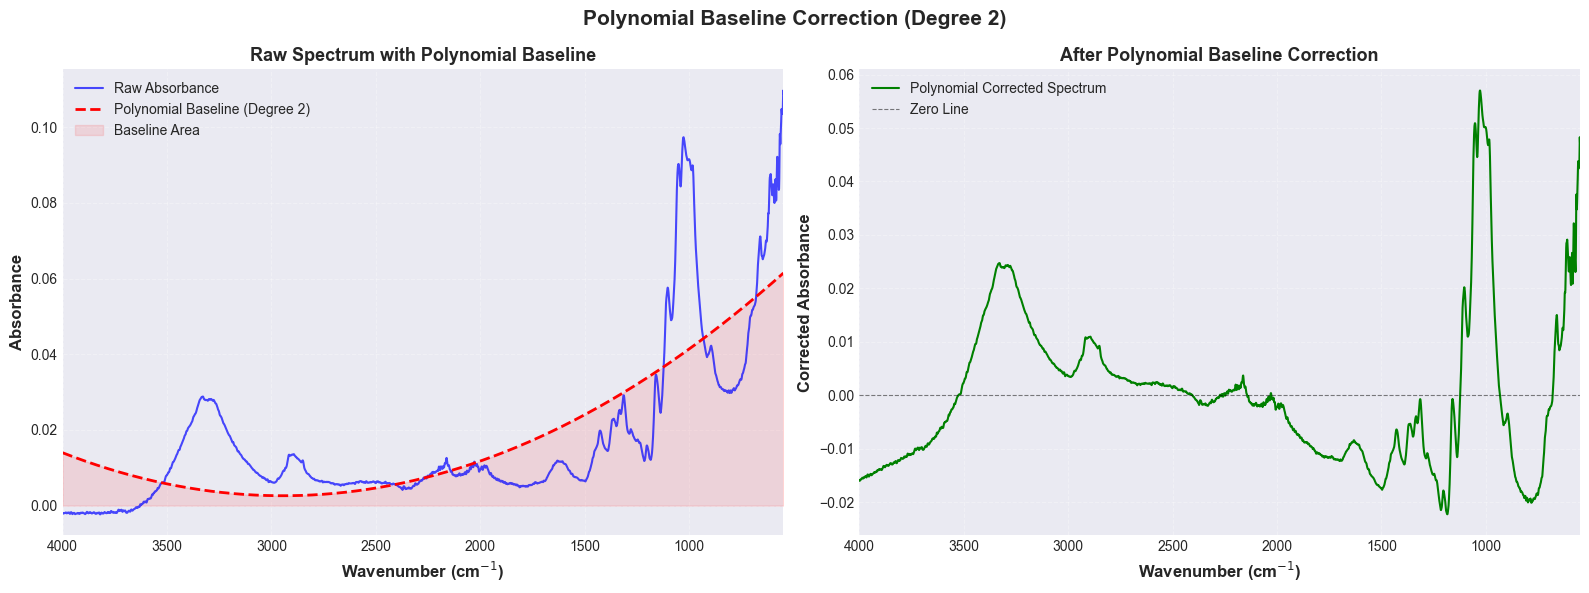


POLYNOMIAL BASELINE CORRECTION RESULTS
Sample: Cotton - Test 1

Original Spectrum:
  Mean absorbance: 0.0174
  Std deviation:   0.0216
  Range:           -0.0023 to 0.1097

Polynomial Baseline:
  Mean baseline:   0.0174
  Baseline range:  0.0026 to 0.0615

Corrected Spectrum:
  Mean absorbance: 0.0000
  Std deviation:   0.0140
  Range:           -0.0223 to 0.0570


In [12]:
# Apply polynomial baseline correction (degree 2)
corrected_poly, baseline_poly = polynomial_baseline_correction(absorbance, wavenumbers, degree=2)

# Create a 2-panel visualization for polynomial baseline correction
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Raw spectrum with fitted polynomial baseline
axes[0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0].plot(wavenumbers, baseline_poly, 'r--', linewidth=2, label='Polynomial Baseline (Degree 2)')
axes[0].fill_between(wavenumbers, 0, baseline_poly, color='red', alpha=0.1, label='Baseline Area')
axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Absorbance', fontsize=12, fontweight='bold')
axes[0].set_title('Raw Spectrum with Polynomial Baseline', fontsize=13, fontweight='bold')
axes[0].invert_xaxis()
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(4000, 550)

# Panel 2: Baseline-corrected spectrum
axes[1].plot(wavenumbers, corrected_poly, 'g-', linewidth=1.5, label='Polynomial Corrected Spectrum')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Zero Line')
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Corrected Absorbance', fontsize=12, fontweight='bold')
axes[1].set_title('After Polynomial Baseline Correction', fontsize=13, fontweight='bold')
axes[1].invert_xaxis()
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlim(4000, 550)

plt.suptitle('Polynomial Baseline Correction (Degree 2)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*70}")
print(f"POLYNOMIAL BASELINE CORRECTION RESULTS")
print(f"{'='*70}")
print(f"Sample: {sample_file.stem}")
print(f"\nOriginal Spectrum:")
print(f"  Mean absorbance: {np.mean(absorbance):.4f}")
print(f"  Std deviation:   {np.std(absorbance):.4f}")
print(f"  Range:           {absorbance.min():.4f} to {absorbance.max():.4f}")

print(f"\nPolynomial Baseline:")
print(f"  Mean baseline:   {np.mean(baseline_poly):.4f}")
print(f"  Baseline range:  {baseline_poly.min():.4f} to {baseline_poly.max():.4f}")

print(f"\nCorrected Spectrum:")
print(f"  Mean absorbance: {np.mean(corrected_poly):.4f}")
print(f"  Std deviation:   {np.std(corrected_poly):.4f}")
print(f"  Range:           {corrected_poly.min():.4f} to {corrected_poly.max():.4f}")
print(f"{'='*70}")



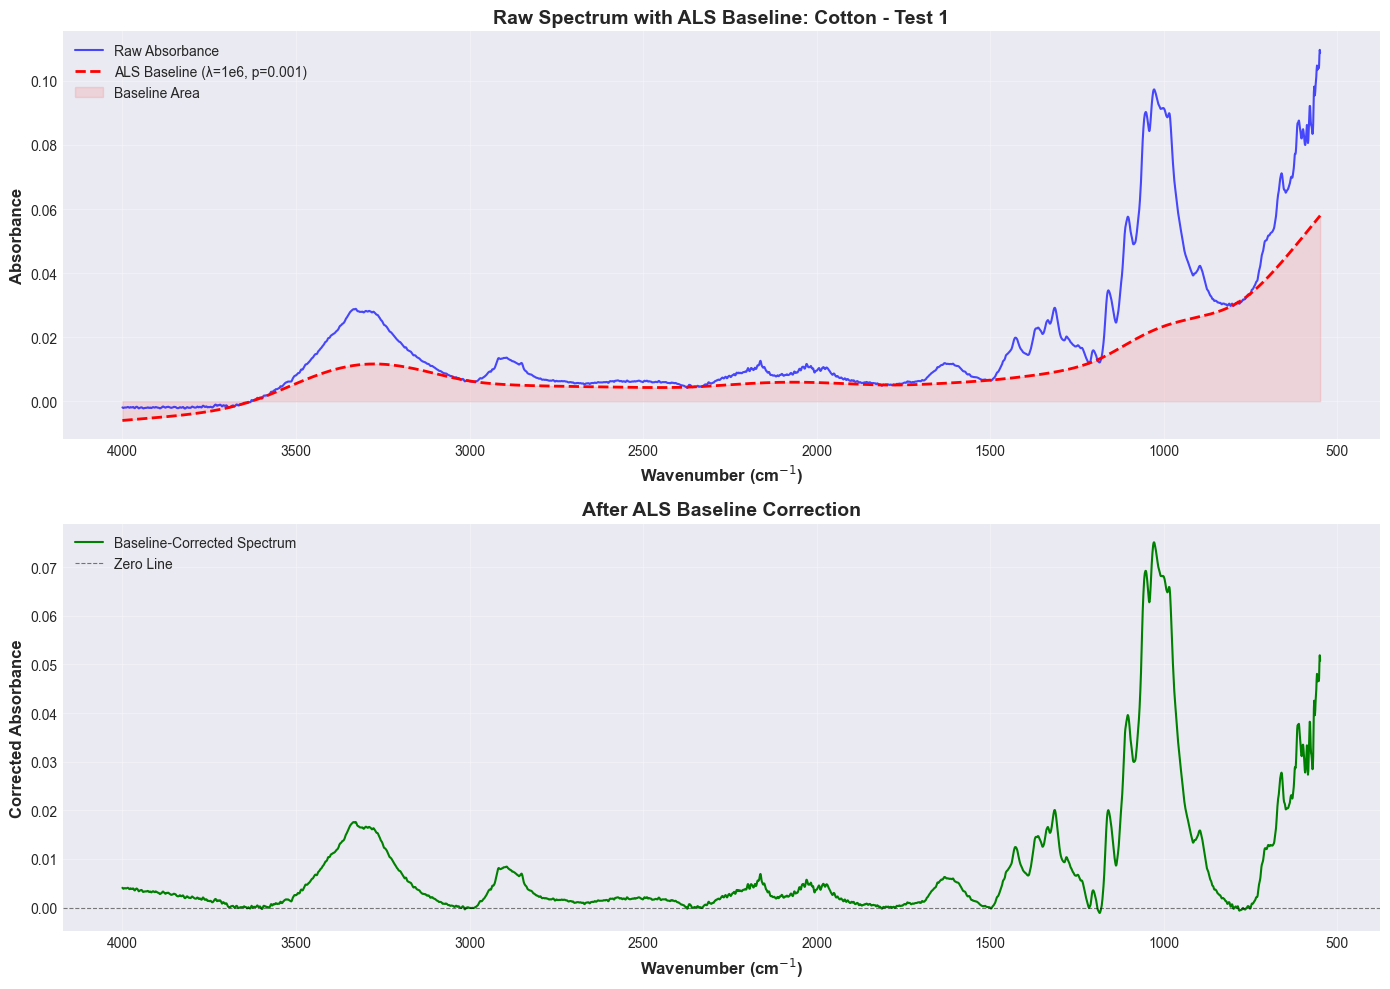


BASELINE CORRECTION RESULTS
Sample: Cotton - Test 1

Original Spectrum:
  Mean absorbance: 0.0174
  Std deviation:   0.0216
  Range:           -0.0023 to 0.1097

Baseline-Corrected Spectrum:
  Mean absorbance: 0.0077
  Std deviation:   0.0128
  Range:           -0.0011 to 0.0751

Baseline Statistics:
  Mean baseline:   0.0097
  Baseline slope:  -0.000019 per point


In [13]:
# Experiment 1: Apply ALS baseline correction to a sample spectrum
# Apply ALS baseline correction
baseline_als = als_baseline_correction(absorbance, lam=1e6, p=0.001)
corrected_als = absorbance - baseline_als

# Visualize the results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Show raw spectrum with fitted baseline
axes[0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0].plot(wavenumbers, baseline_als, 'r--', linewidth=2, label='ALS Baseline (λ=1e6, p=0.001)')
axes[0].fill_between(wavenumbers, 0, baseline_als, color='red', alpha=0.1, label='Baseline Area')
axes[0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Absorbance', fontsize=12, fontweight='bold')
axes[0].set_title(f'Raw Spectrum with ALS Baseline: {sample_file.stem}', fontsize=14, fontweight='bold')
axes[0].invert_xaxis()
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Bottom plot: Show baseline-corrected spectrum
axes[1].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, label='Baseline-Corrected Spectrum')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Zero Line')
axes[1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Corrected Absorbance', fontsize=12, fontweight='bold')
axes[1].set_title('After ALS Baseline Correction', fontsize=14, fontweight='bold')
axes[1].invert_xaxis()
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\n{'='*70}")
print(f"BASELINE CORRECTION RESULTS")
print(f"{'='*70}")
print(f"Sample: {sample_file.stem}")
print(f"\nOriginal Spectrum:")
print(f"  Mean absorbance: {np.mean(absorbance):.4f}")
print(f"  Std deviation:   {np.std(absorbance):.4f}")
print(f"  Range:           {absorbance.min():.4f} to {absorbance.max():.4f}")

print(f"\nBaseline-Corrected Spectrum:")
print(f"  Mean absorbance: {np.mean(corrected_als):.4f}")
print(f"  Std deviation:   {np.std(corrected_als):.4f}")
print(f"  Range:           {corrected_als.min():.4f} to {corrected_als.max():.4f}")

print(f"\nBaseline Statistics:")
print(f"  Mean baseline:   {np.mean(baseline_als):.4f}")
print(f"  Baseline slope:  {(baseline_als[0] - baseline_als[-1]) / len(baseline_als):.6f} per point")
print(f"{'='*70}")

## Step 2: Standard Normal Variate (SNV) - Scatter Correction

### **What is Multiplicative Scatter?**
When light passes through a sample, **physical properties** (not just chemical composition) affect the spectrum:
- **Particle size variations** → Different scattering intensities
- **Sample density differences** → Overall intensity shifts
- **Surface roughness** → Multiplicative scaling effects

These create **multiplicative scatter** - the entire spectrum is scaled up or down, making samples look different even if chemically identical.

### **How Does SNV Work?**
SNV standardizes each spectrum individually:
1. **Centers the spectrum**: Subtracts the mean → shifts to zero
2. **Scales to unit variance**: Divides by std deviation → standardizes intensity
3. **Result**: All spectra have mean=0, std=1

### **Formula:**
$$\text{SNV}(x) = \frac{x - \bar{x}}{\sigma_x}$$

Where:
- $x$ = original spectrum
- $\bar{x}$ = mean of spectrum
- $\sigma_x$ = standard deviation of spectrum

### **When to Use SNV:**
- ✅ **After baseline correction** (removes additive effects first)
- ✅ When samples have **different particle sizes** or **packing densities**
- ✅ For **classification tasks** (makes spectra comparable)
- ❌ For **quantitative analysis** (removes concentration information)

### **Reference:**
Barnes, R.J., Dhanoa, M.S., Lister, S.J. (1989). "Standard Normal Variate Transformation and De-trending of Near-Infrared Diffuse Reflectance Spectra"

In [14]:
def standard_normal_variate(spectrum):
    """
    Standard Normal Variate (SNV) transformation.
    
    Centers each spectrum to mean=0 and scales to std=1.
    Removes multiplicative scatter effects while preserving peak patterns.
    
    Parameters:
    -----------
    spectrum : array-like
        Input spectrum
    
    Returns:
    --------
    snv_spectrum : ndarray
        SNV-transformed spectrum
    """
    mean_val = np.mean(spectrum)
    std_val = np.std(spectrum)
    
    # Avoid division by zero
    if std_val == 0:
        return spectrum - mean_val
    
    snv_spectrum = (spectrum - mean_val) / std_val
    return snv_spectrum

### SNV Applied Directly to Raw Absorbance (Without Baseline Correction)

Sometimes it's useful to apply SNV directly to raw absorbance without baseline correction first. This approach:
- Standardizes intensity variations immediately
- Preserves the original baseline structure
- Can be faster for quick exploratory analysis
- Useful when baseline shifts are minimal

However, for best results, ALS baseline correction followed by SNV is generally recommended.

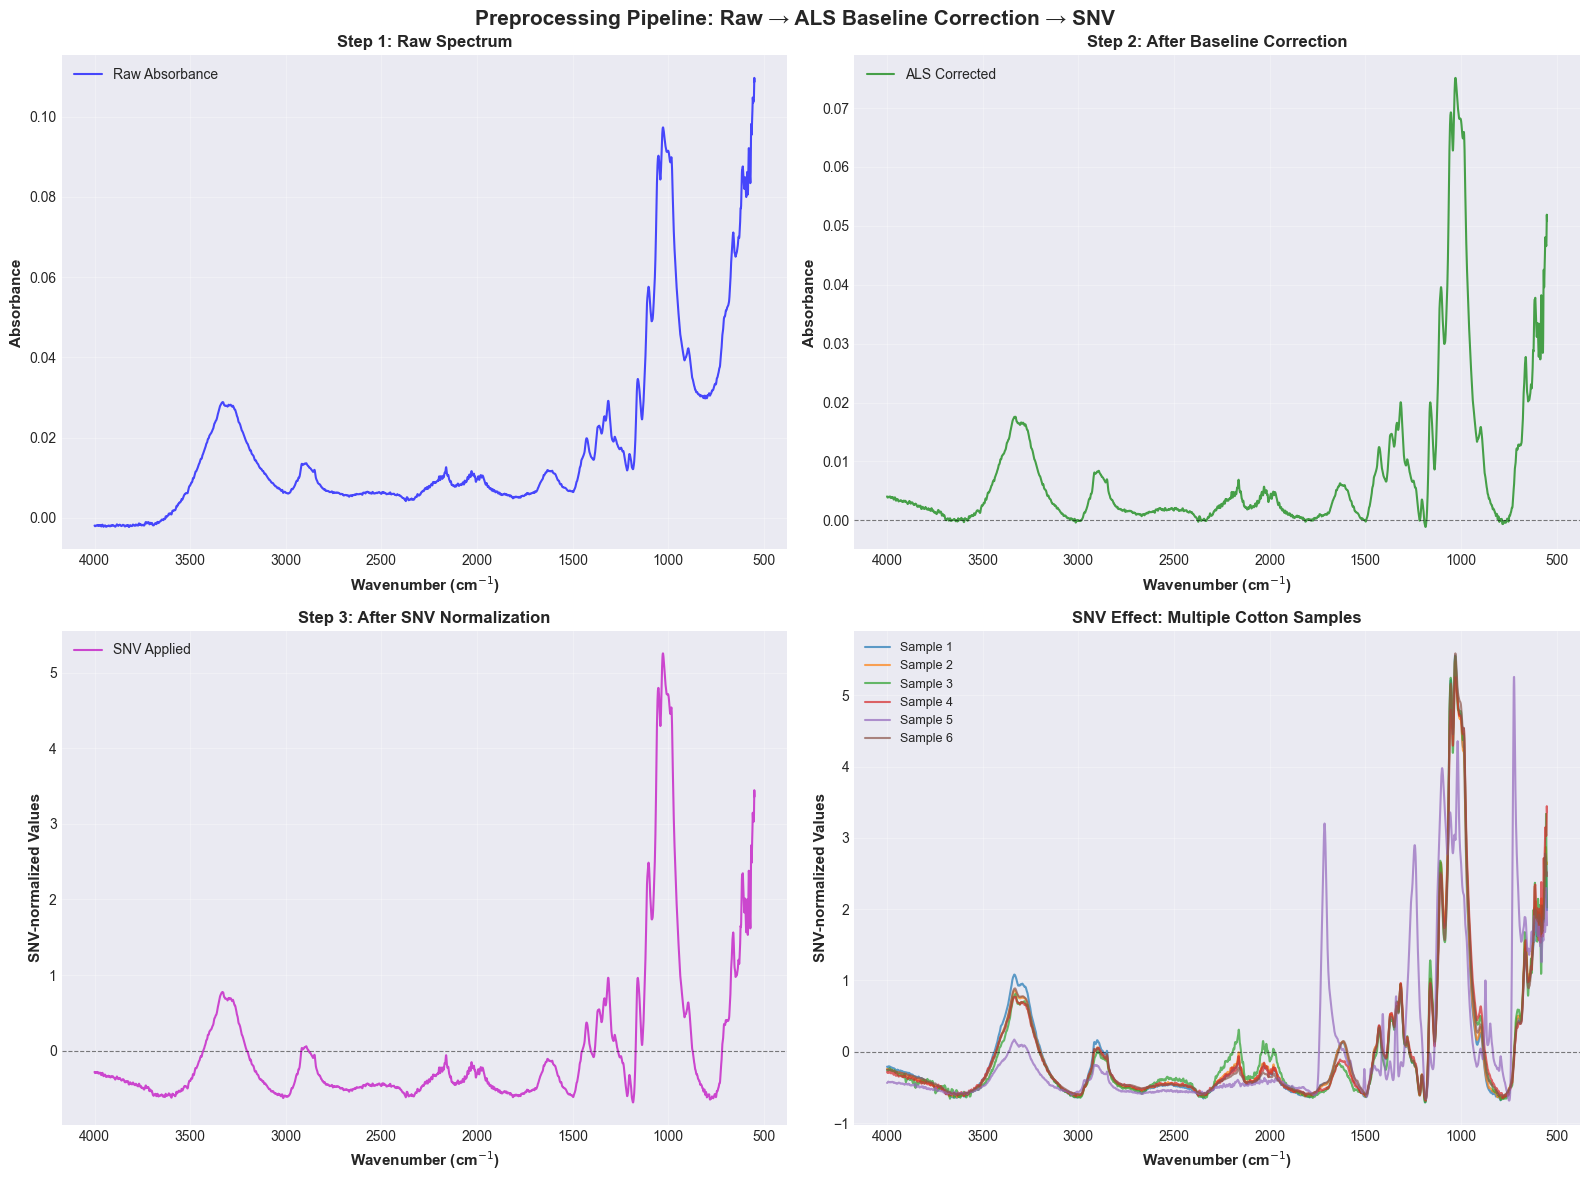


SNV TRANSFORMATION RESULTS

Before SNV (ALS-corrected):
  Mean: 0.0077
  Std:  0.0128
  Min:  -0.0011
  Max:  0.0751

After SNV:
  Mean: 0.000000  ← Should be ~0
  Std:  1.000000  ← Should be ~1
  Min:  -0.6846
  Max:  5.2527


In [15]:
# Experiment 2: Apply SNV to baseline-corrected spectrum
# Apply SNV to the ALS-corrected spectrum from previous step
snv_spectrum = standard_normal_variate(corrected_als)

# Let's also load and process multiple Cotton samples to see SNV effect
cotton_files = [f for f in csv_files if 'Cotton' in f.stem]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Compare original vs baseline-corrected vs SNV for single sample
axes[0, 0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Step 1: Raw Spectrum', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, label='ALS Corrected', alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Step 2: After Baseline Correction', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(wavenumbers, snv_spectrum, 'm-', linewidth=1.5, label='SNV Applied', alpha=0.7)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Step 3: After SNV Normalization', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Show effect of SNV on multiple samples (within-class variability reduction)
axes[1, 1].set_title('SNV Effect: Multiple Cotton Samples', fontsize=12, fontweight='bold')

# Process all Cotton samples and show before/after SNV
for idx, cotton_file in enumerate(cotton_files):
    df = pd.read_csv(cotton_file, skiprows=1, header=0)
    wn = df['cm-1'].values
    trans = df['%T'].values
    abs_raw = 2 - np.log10(trans + 1e-9)
    
    # Apply ALS then SNV
    baseline = als_baseline_correction(abs_raw, lam=1e6, p=0.001)
    corrected = abs_raw - baseline
    snv = standard_normal_variate(corrected)
    
    # Plot SNV-normalized
    axes[1, 1].plot(wn, snv, linewidth=1.5, label=f'Sample {idx+1}', alpha=0.7)

axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Preprocessing Pipeline: Raw → ALS Baseline Correction → SNV', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print(f"\n{'='*70}")
print(f"SNV TRANSFORMATION RESULTS")
print(f"{'='*70}")
print(f"\nBefore SNV (ALS-corrected):")
print(f"  Mean: {np.mean(corrected_als):.4f}")
print(f"  Std:  {np.std(corrected_als):.4f}")
print(f"  Min:  {corrected_als.min():.4f}")
print(f"  Max:  {corrected_als.max():.4f}")

print(f"\nAfter SNV:")
print(f"  Mean: {np.mean(snv_spectrum):.6f}  ← Should be ~0")
print(f"  Std:  {np.std(snv_spectrum):.6f}  ← Should be ~1")
print(f"  Min:  {snv_spectrum.min():.4f}")
print(f"  Max:  {snv_spectrum.max():.4f}")

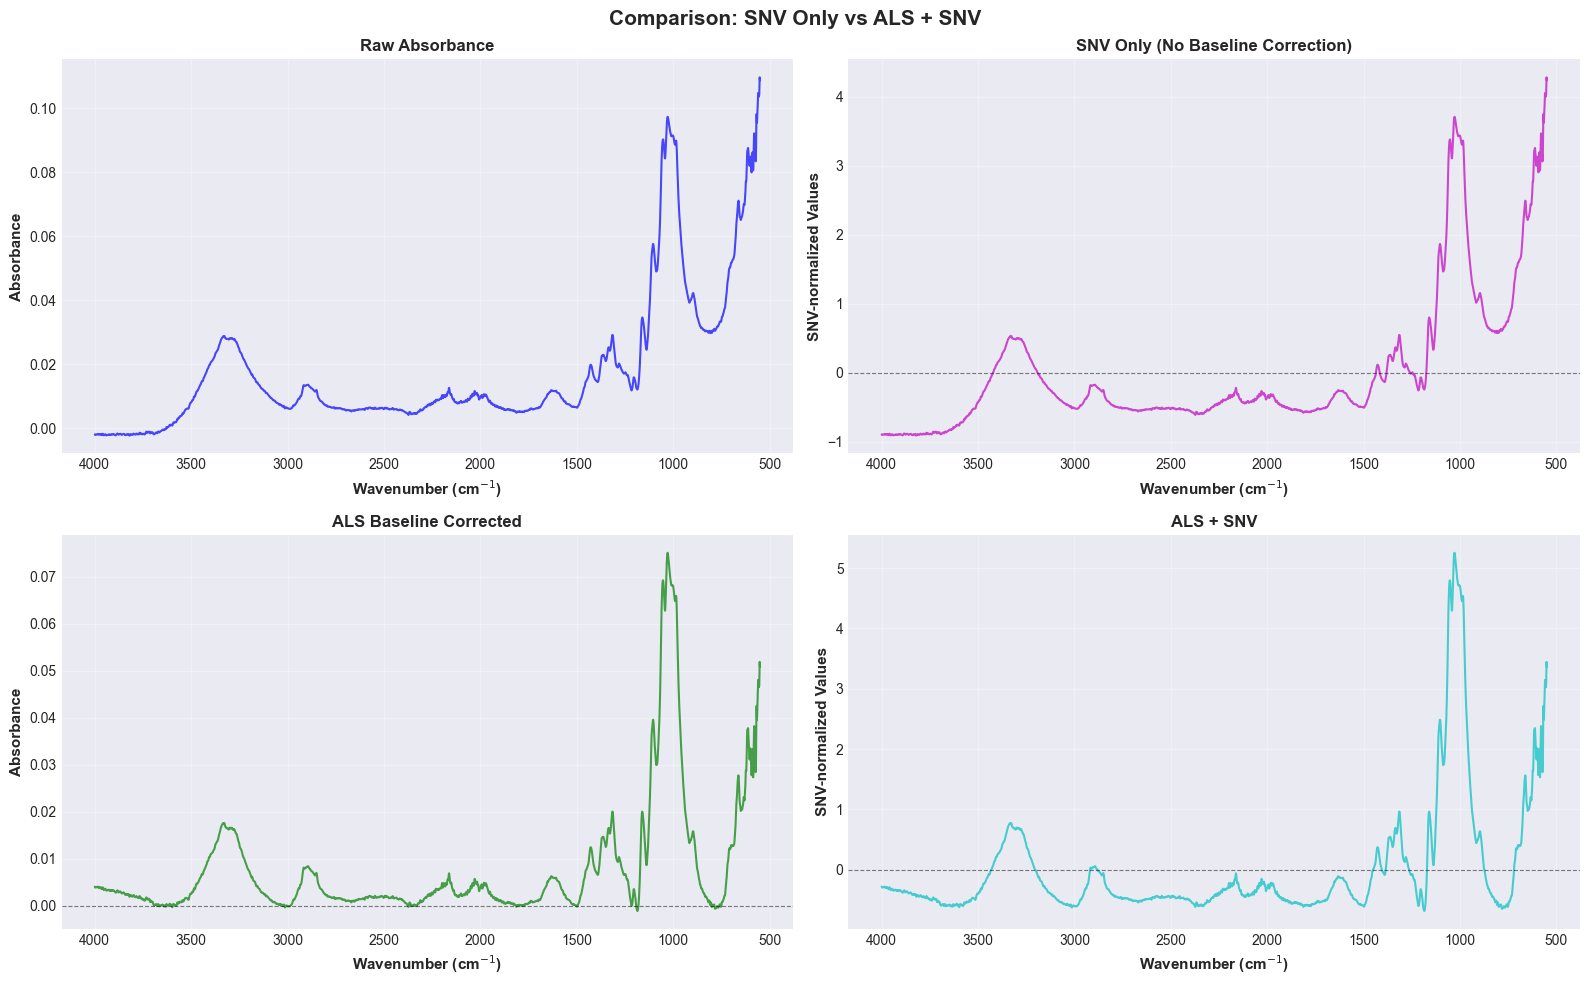


SNV COMPARISON: Raw vs Baseline-Corrected

SNV on Raw Absorbance:
  Mean: -0.000000
  Std:  1.000000
  Min:  -0.9128
  Max:  4.2775

SNV on Baseline-Corrected:
  Mean: 0.000000
  Std:  1.000000
  Min:  -0.6846
  Max:  5.2527

Note: Both methods standardize to mean~0, std~1, but ALS+SNV
      removes baseline drift first for better peak isolation.


In [16]:
# Apply SNV directly to raw absorbance (without baseline correction)
snv_raw = standard_normal_variate(absorbance)

# Visualize the difference between SNV with and without baseline correction
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Raw absorbance
axes[0, 0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, alpha=0.7)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Raw Absorbance', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: SNV applied to raw absorbance
axes[0, 1].plot(wavenumbers, snv_raw, 'm-', linewidth=1.5, alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[0, 1].set_title('SNV Only (No Baseline Correction)', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Baseline-corrected spectrum
axes[1, 0].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, alpha=0.7)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[1, 0].set_title('ALS Baseline Corrected', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: SNV applied to baseline-corrected spectrum
axes[1, 1].plot(wavenumbers, snv_spectrum, 'c-', linewidth=1.5, alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].set_title('ALS + SNV', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Comparison: SNV Only vs ALS + SNV', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\n{'='*70}")
print(f"SNV COMPARISON: Raw vs Baseline-Corrected")
print(f"{'='*70}")

print(f"\nSNV on Raw Absorbance:")
print(f"  Mean: {np.mean(snv_raw):.6f}")
print(f"  Std:  {np.std(snv_raw):.6f}")
print(f"  Min:  {snv_raw.min():.4f}")
print(f"  Max:  {snv_raw.max():.4f}")

print(f"\nSNV on Baseline-Corrected:")
print(f"  Mean: {np.mean(snv_spectrum):.6f}")
print(f"  Std:  {np.std(snv_spectrum):.6f}")
print(f"  Min:  {snv_spectrum.min():.4f}")
print(f"  Max:  {snv_spectrum.max():.4f}")

print(f"\nNote: Both methods standardize to mean~0, std~1, but ALS+SNV")
print(f"      removes baseline drift first for better peak isolation.")
print(f"{'='*70}")

# SNV applied to Polynomial corrected spectrum

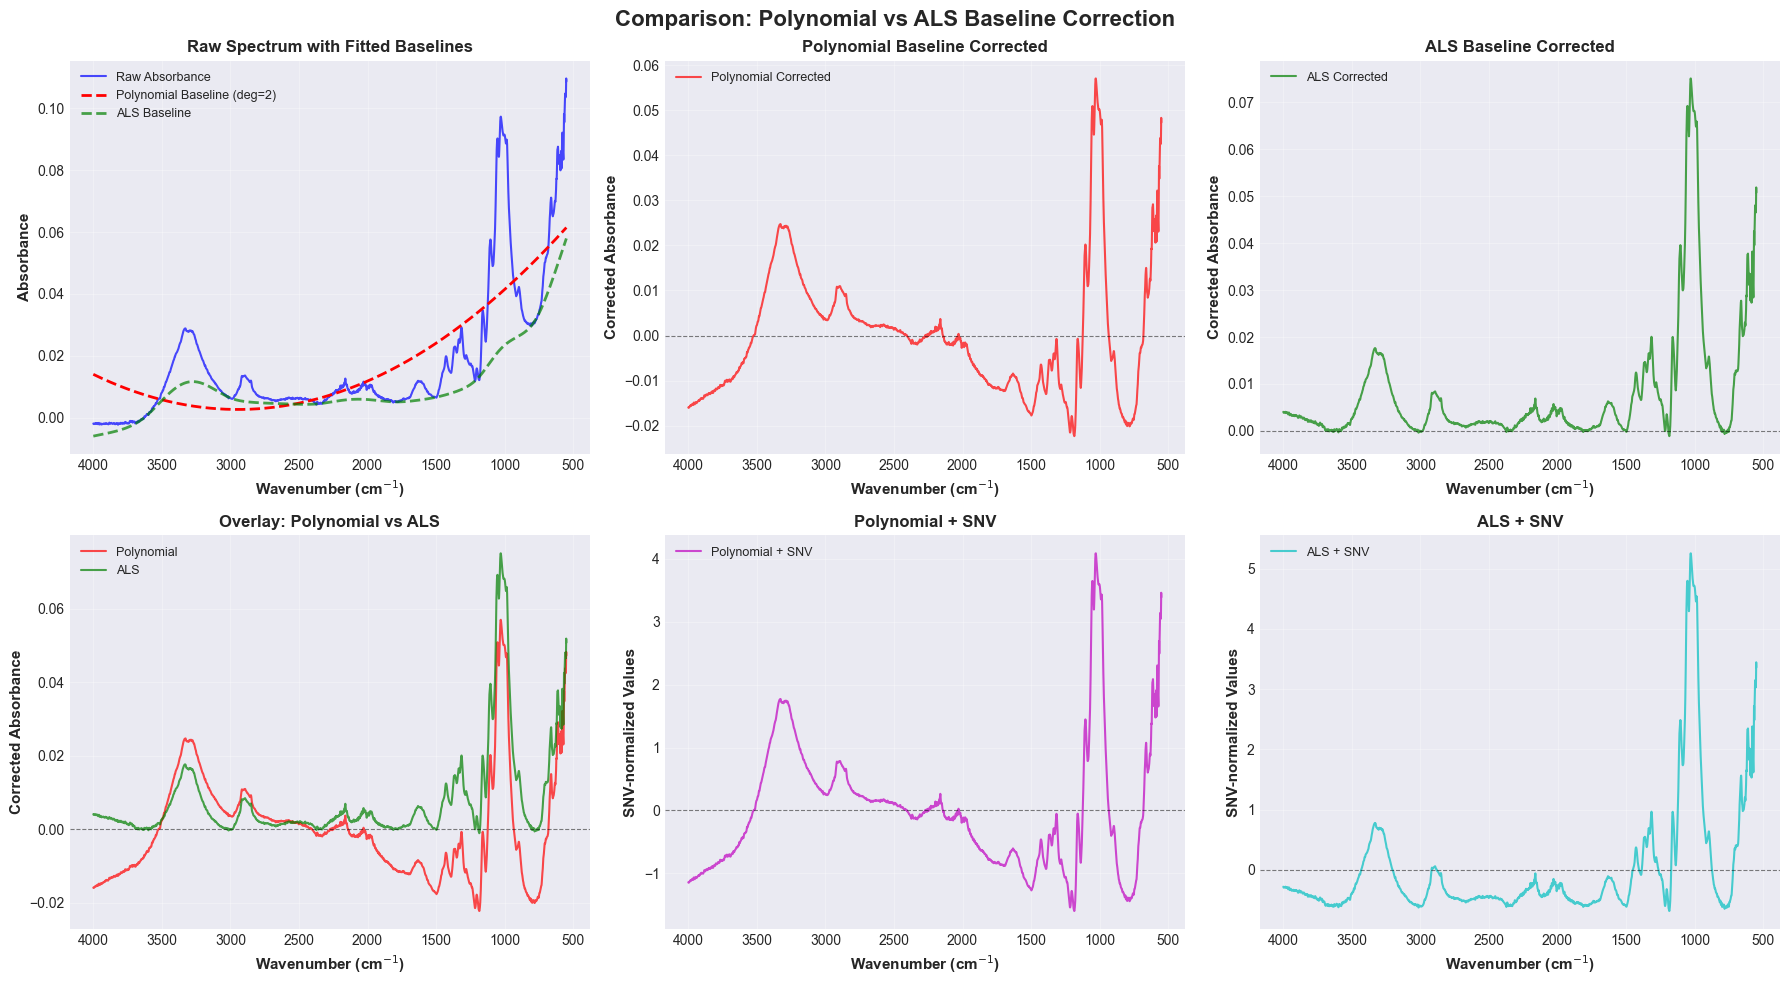


POLYNOMIAL vs ALS BASELINE CORRECTION COMPARISON

Polynomial Baseline Correction (degree=2):
  Corrected Mean: 0.0000
  Corrected Std:  0.0140
  Baseline Mean:  0.0174

ALS Baseline Correction:
  Corrected Mean: 0.0077
  Corrected Std:  0.0128
  Baseline Mean:  0.0097

After SNV Normalization:
  Polynomial + SNV: Mean=0.000000, Std=1.000000
  ALS + SNV:        Mean=0.000000, Std=1.000000


In [17]:
# Apply SNV to polynomial-corrected spectrum
snv_poly = standard_normal_variate(corrected_poly)

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Baseline correction comparison
axes[0, 0].plot(wavenumbers, absorbance, 'b-', linewidth=1.5, label='Raw Absorbance', alpha=0.7)
axes[0, 0].plot(wavenumbers, baseline_poly, 'r--', linewidth=2, label='Polynomial Baseline (deg=2)')
axes[0, 0].plot(wavenumbers, baseline_als, 'g--', linewidth=2, label='ALS Baseline', alpha=0.7)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Raw Spectrum with Fitted Baselines', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(wavenumbers, corrected_poly, 'r-', linewidth=1.5, label='Polynomial Corrected', alpha=0.7)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Corrected Absorbance', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Polynomial Baseline Corrected', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, label='ALS Corrected', alpha=0.7)
axes[0, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 2].set_ylabel('Corrected Absorbance', fontsize=11, fontweight='bold')
axes[0, 2].set_title('ALS Baseline Corrected', fontsize=12, fontweight='bold')
axes[0, 2].invert_xaxis()
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: With SNV normalization
axes[1, 0].plot(wavenumbers, corrected_poly, 'r-', linewidth=1.5, alpha=0.7)
axes[1, 0].plot(wavenumbers, corrected_als, 'g-', linewidth=1.5, alpha=0.7)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Corrected Absorbance', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Overlay: Polynomial vs ALS', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].legend(['Polynomial', 'ALS'], fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(wavenumbers, snv_poly, 'm-', linewidth=1.5, label='Polynomial + SNV', alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Polynomial + SNV', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(wavenumbers, snv_spectrum, 'c-', linewidth=1.5, label='ALS + SNV', alpha=0.7)
axes[1, 2].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 2].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('SNV-normalized Values', fontsize=11, fontweight='bold')
axes[1, 2].set_title('ALS + SNV', fontsize=12, fontweight='bold')
axes[1, 2].invert_xaxis()
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Comparison: Polynomial vs ALS Baseline Correction', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\n{'='*80}")
print(f"POLYNOMIAL vs ALS BASELINE CORRECTION COMPARISON")
print(f"{'='*80}")

print(f"\nPolynomial Baseline Correction (degree=2):")
print(f"  Corrected Mean: {np.mean(corrected_poly):.4f}")
print(f"  Corrected Std:  {np.std(corrected_poly):.4f}")
print(f"  Baseline Mean:  {np.mean(baseline_poly):.4f}")

print(f"\nALS Baseline Correction:")
print(f"  Corrected Mean: {np.mean(corrected_als):.4f}")
print(f"  Corrected Std:  {np.std(corrected_als):.4f}")
print(f"  Baseline Mean:  {np.mean(baseline_als):.4f}")

print(f"\nAfter SNV Normalization:")
print(f"  Polynomial + SNV: Mean={np.mean(snv_poly):.6f}, Std={np.std(snv_poly):.6f}")
print(f"  ALS + SNV:        Mean={np.mean(snv_spectrum):.6f}, Std={np.std(snv_spectrum):.6f}")

## Step 3: Savitzky-Golay Derivatives - Peak Enhancement

### **Why Use Derivatives?**
Spectral derivatives are powerful tools that:
1. **Remove baseline effects** - Any polynomial baseline becomes zero after differentiation
2. **Resolve overlapping peaks** - Separate closely spaced absorption bands
3. **Enhance subtle features** - Amplify small spectral differences
4. **Reduce systematic variations** - Focus on local changes rather than absolute intensities

### **What is Savitzky-Golay Filtering?**
Instead of simple numerical differentiation (which amplifies noise), Savitzky-Golay:
- Fits a **polynomial** to a moving window of data points
- Computes the derivative of the **fitted polynomial** (not raw data)
- Result: **Smooth derivatives** that preserve peak shapes

### **1st Derivative:**
- **Physical meaning**: Rate of change of absorbance
- **Visual effect**: Peaks become **S-shaped curves** (rising then falling)
- **Zero crossings**: Occur at original peak maxima
- **Applications**: Baseline removal, peak detection, overlapping peak separation

### **2nd Derivative:**
- **Physical meaning**: Curvature of the spectrum
- **Visual effect**: Peaks become **inverted V-shapes** (negative peaks)
- **Minima**: Occur at original peak maxima
- **Applications**: Even better peak resolution, subtle feature detection

### **Key Parameters:**
- **window_length**: Number of points in the smoothing window (must be odd)
  - **Larger** = more smoothing, less noise, but can blur narrow peaks
  - **Smaller** = less smoothing, more noise, better peak resolution
  - Typical: 5-21 points
  
- **polyorder**: Polynomial degree for fitting
  - Typical: 2-4 (cubic or quadratic)
  - Higher order can overfit

### **Important Note:**
⚠️ Derivatives amplify **high-frequency noise**. Always apply smoothing (via proper window_length selection) or pre-smooth your data.

### **Reference:**
Savitzky, A. & Golay, M.J.E. (1964). "Smoothing and Differentiation of Data by Simplified Least Squares Procedures"

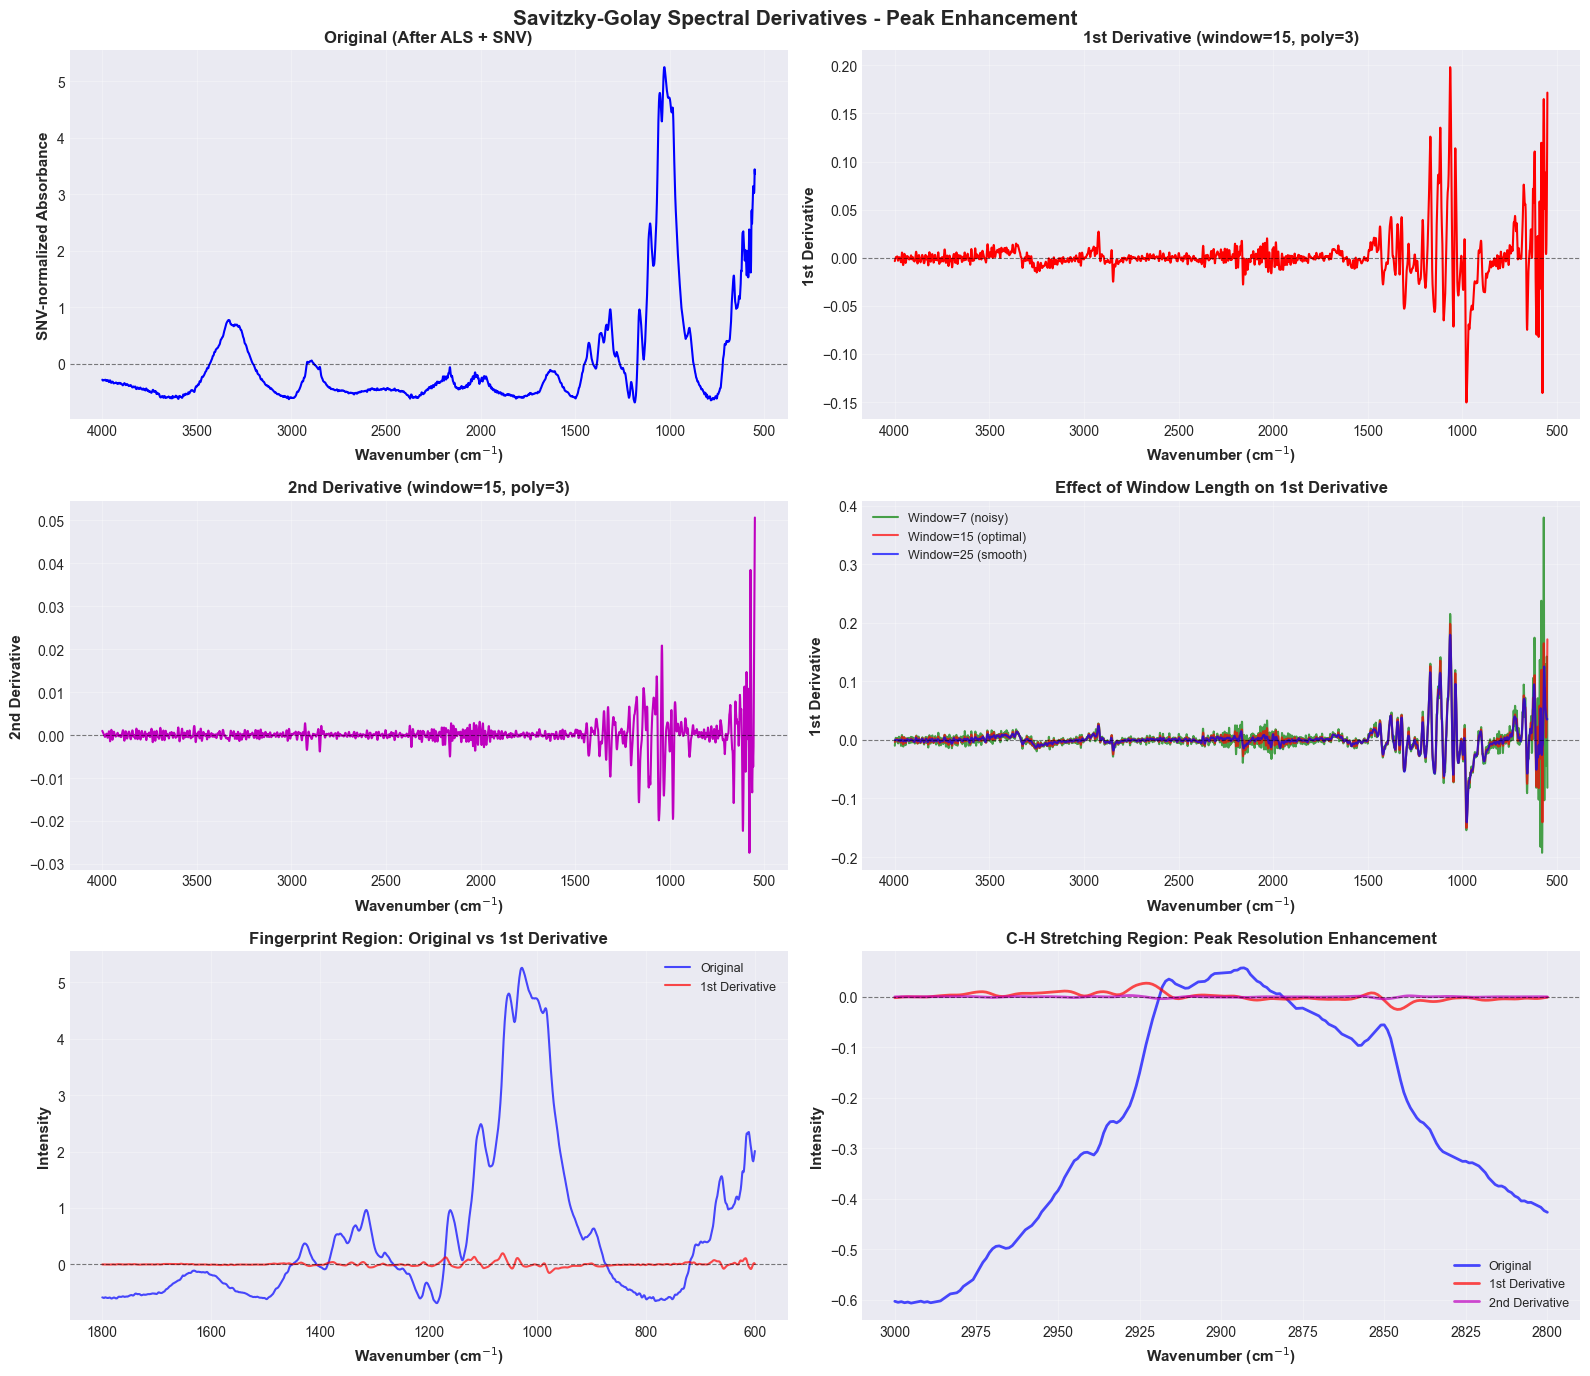


SPECTRAL DERIVATIVES ANALYSIS

Original Spectrum (SNV-normalized):
  Range: -0.6846 to 5.2527
  Std:   1.0000

1st Derivative:
  Range: -0.1504 to 0.1980
  Std:   0.0249
  Zero crossings: 303 (indicates peak positions)

2nd Derivative:
  Range: -0.0274 to 0.0506
  Std:   0.0036
  Minima count: 277 (indicates sharp peaks)


In [18]:
# Experiment 3: Apply Savitzky-Golay derivatives
# We'll use the SNV-normalized spectrum from the previous step

# Apply 1st derivative
deriv1 = savgol_filter(snv_spectrum, window_length=15, polyorder=3, deriv=1)

# Apply 2nd derivative
deriv2 = savgol_filter(snv_spectrum, window_length=15, polyorder=3, deriv=2)

# Also compute derivatives at different window sizes to show the effect
deriv1_small = savgol_filter(snv_spectrum, window_length=7, polyorder=3, deriv=1)
deriv1_large = savgol_filter(snv_spectrum, window_length=25, polyorder=3, deriv=1)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 1: Original SNV spectrum
axes[0, 0].plot(wavenumbers, snv_spectrum, 'b-', linewidth=1.5)
axes[0, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('SNV-normalized Absorbance', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Original (After ALS + SNV)', fontsize=12, fontweight='bold')
axes[0, 0].invert_xaxis()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: 1st Derivative
axes[0, 1].plot(wavenumbers, deriv1, 'r-', linewidth=1.5)
axes[0, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('1st Derivative', fontsize=11, fontweight='bold')
axes[0, 1].set_title('1st Derivative (window=15, poly=3)', fontsize=12, fontweight='bold')
axes[0, 1].invert_xaxis()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: 2nd Derivative
axes[1, 0].plot(wavenumbers, deriv2, 'm-', linewidth=1.5)
axes[1, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('2nd Derivative', fontsize=11, fontweight='bold')
axes[1, 0].set_title('2nd Derivative (window=15, poly=3)', fontsize=12, fontweight='bold')
axes[1, 0].invert_xaxis()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Comparing different window lengths for 1st derivative
axes[1, 1].plot(wavenumbers, deriv1_small, 'g-', linewidth=1.5, label='Window=7 (noisy)', alpha=0.7)
axes[1, 1].plot(wavenumbers, deriv1, 'r-', linewidth=1.5, label='Window=15 (optimal)', alpha=0.7)
axes[1, 1].plot(wavenumbers, deriv1_large, 'b-', linewidth=1.5, label='Window=25 (smooth)', alpha=0.7)
axes[1, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('1st Derivative', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Effect of Window Length on 1st Derivative', fontsize=12, fontweight='bold')
axes[1, 1].invert_xaxis()
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Fingerprint region comparison (1800-600 cm⁻¹)
fingerprint_mask = (wavenumbers >= 600) & (wavenumbers <= 1800)
axes[2, 0].plot(wavenumbers[fingerprint_mask], snv_spectrum[fingerprint_mask], 
                'b-', linewidth=1.5, label='Original', alpha=0.7)
axes[2, 0].plot(wavenumbers[fingerprint_mask], deriv1[fingerprint_mask], 
                'r-', linewidth=1.5, label='1st Derivative', alpha=0.7)
axes[2, 0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2, 0].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[2, 0].set_ylabel('Intensity', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Fingerprint Region: Original vs 1st Derivative', fontsize=12, fontweight='bold')
axes[2, 0].invert_xaxis()
axes[2, 0].legend(fontsize=9)
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Show how derivatives resolve overlapping peaks
# Focus on C-H stretching region (3000-2800 cm⁻¹)
ch_mask = (wavenumbers >= 2800) & (wavenumbers <= 3000)
axes[2, 1].plot(wavenumbers[ch_mask], snv_spectrum[ch_mask], 
                'b-', linewidth=2, label='Original', alpha=0.7)
axes[2, 1].plot(wavenumbers[ch_mask], deriv1[ch_mask], 
                'r-', linewidth=2, label='1st Derivative', alpha=0.7)
axes[2, 1].plot(wavenumbers[ch_mask], deriv2[ch_mask], 
                'm-', linewidth=2, label='2nd Derivative', alpha=0.7)
axes[2, 1].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2, 1].set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=11, fontweight='bold')
axes[2, 1].set_ylabel('Intensity', fontsize=11, fontweight='bold')
axes[2, 1].set_title('C-H Stretching Region: Peak Resolution Enhancement', fontsize=12, fontweight='bold')
axes[2, 1].invert_xaxis()
axes[2, 1].legend(fontsize=9)
axes[2, 1].grid(True, alpha=0.3)

plt.suptitle('Savitzky-Golay Spectral Derivatives - Peak Enhancement', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*70}")
print(f"SPECTRAL DERIVATIVES ANALYSIS")
print(f"{'='*70}")

print(f"\nOriginal Spectrum (SNV-normalized):")
print(f"  Range: {snv_spectrum.min():.4f} to {snv_spectrum.max():.4f}")
print(f"  Std:   {np.std(snv_spectrum):.4f}")

print(f"\n1st Derivative:")
print(f"  Range: {deriv1.min():.4f} to {deriv1.max():.4f}")
print(f"  Std:   {np.std(deriv1):.4f}")
print(f"  Zero crossings: {np.sum(np.diff(np.sign(deriv1)) != 0)} (indicates peak positions)")

print(f"\n2nd Derivative:")
print(f"  Range: {deriv2.min():.4f} to {deriv2.max():.4f}")
print(f"  Std:   {np.std(deriv2):.4f}")
print(f"  Minima count: {np.sum(np.diff(np.sign(np.diff(deriv2))) > 0)} (indicates sharp peaks)")

## Step 4: Comparing All Preprocessing Techniques

Now let's apply all techniques to **multiple fabric types** to see how they affect **between-class discrimination**.

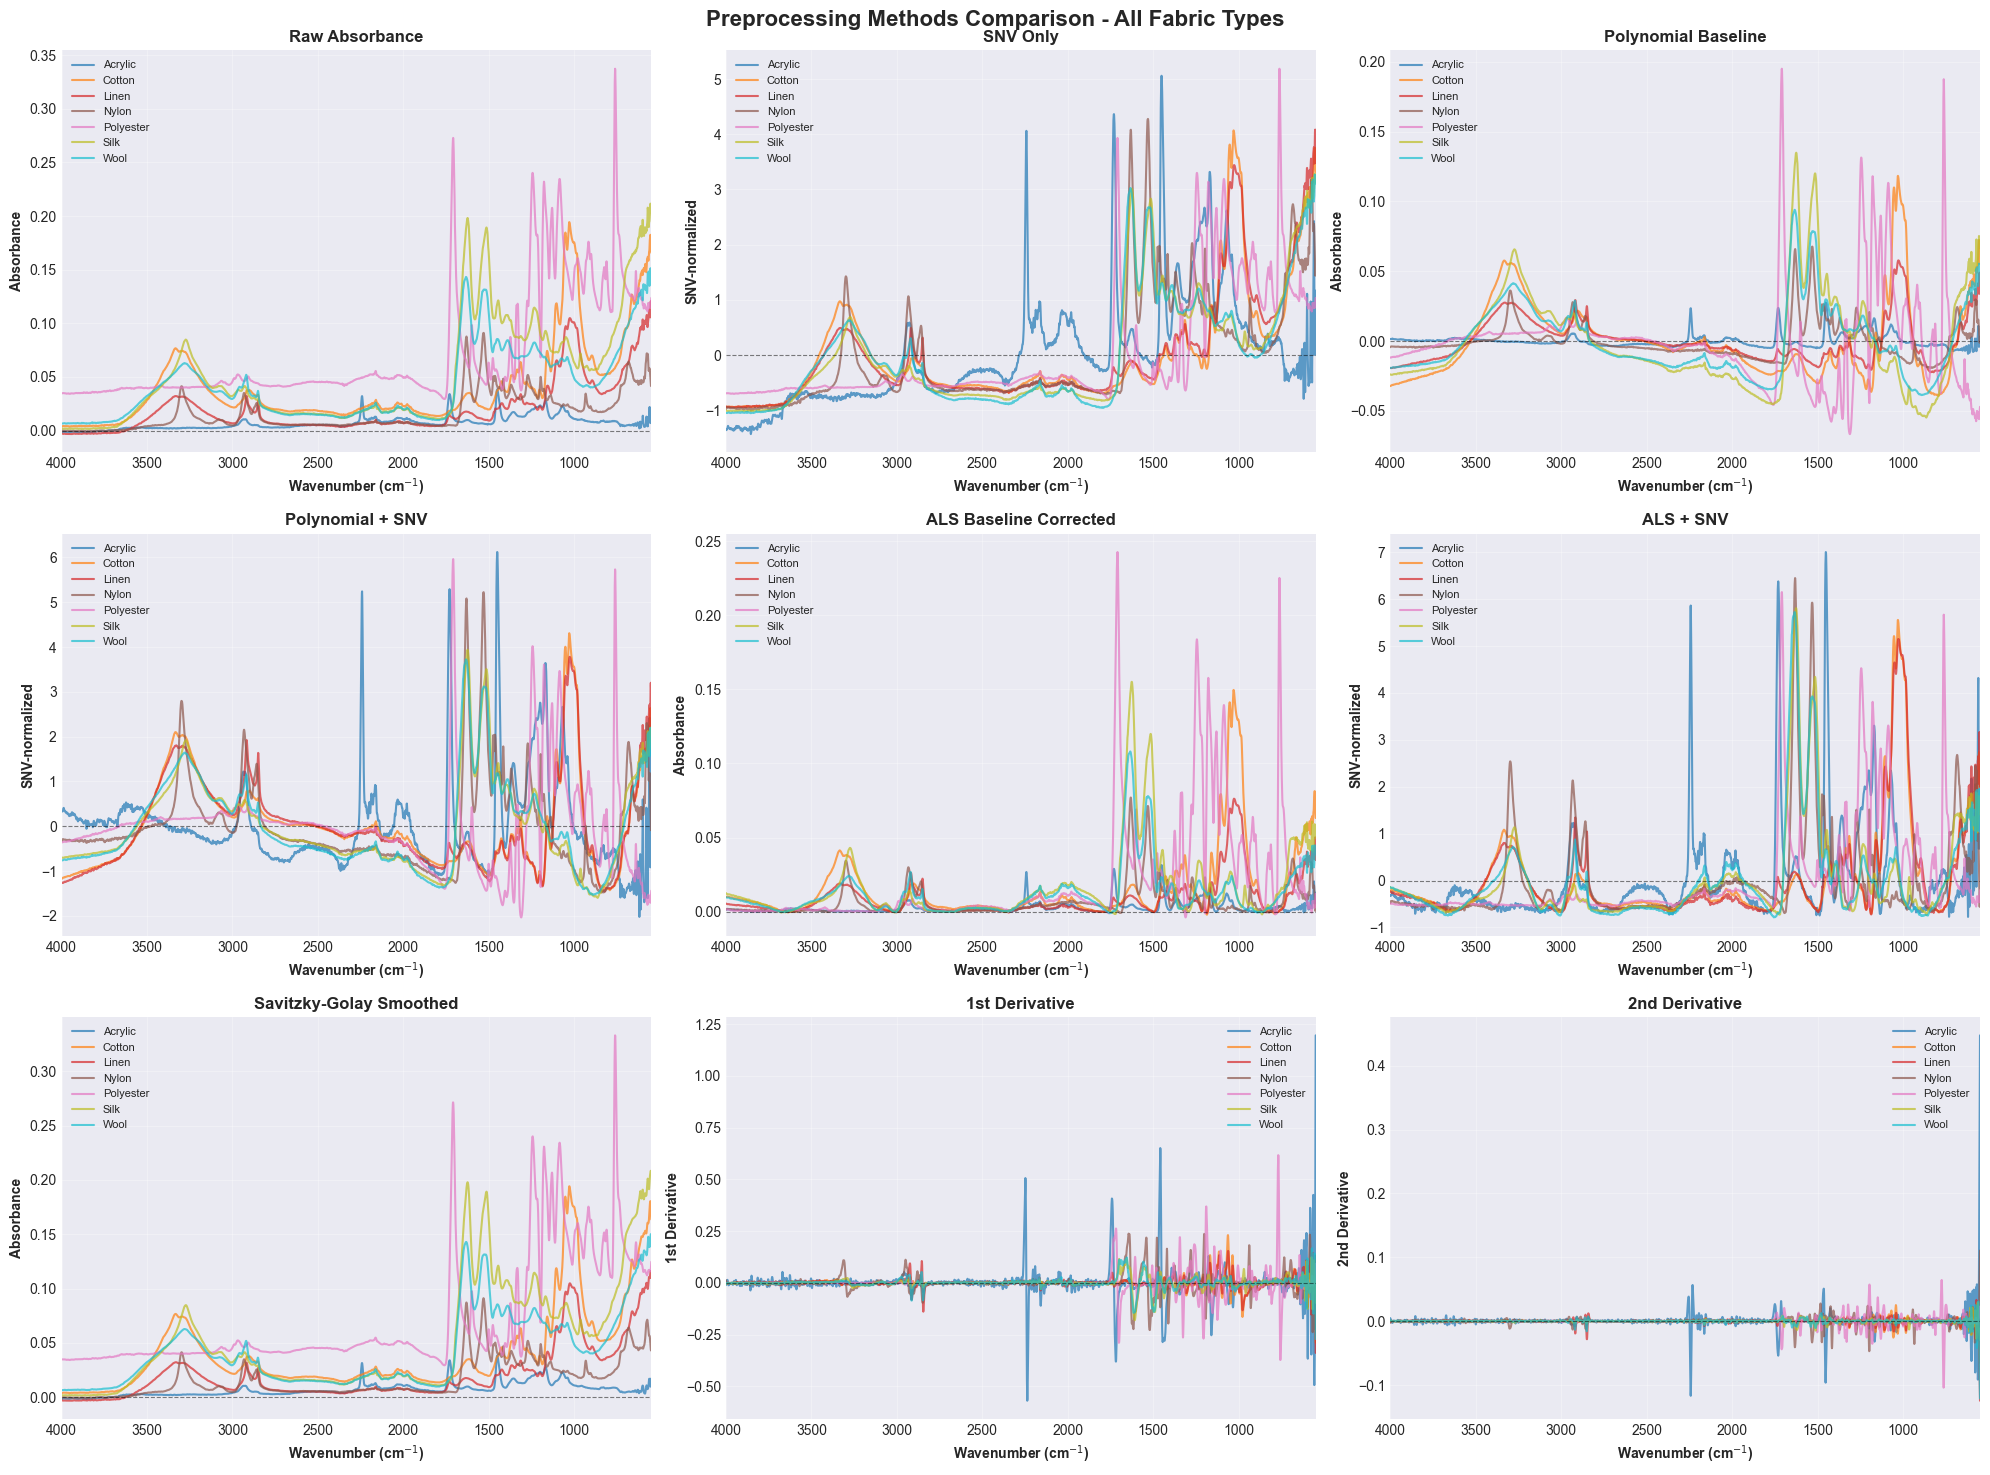

In [19]:
# Experiment 4: Apply all preprocessing methods to all fabric types
# Select one representative sample from each fabric type

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

preprocessing_methods = [
    ('Raw Absorbance', lambda x: x, 'Absorbance'),
    ('SNV Only', lambda x: standard_normal_variate(x), 'SNV-normalized'),
    ('Polynomial Baseline', lambda x: polynomial_baseline_correction(x, degree=2)[0], 'Absorbance'),
    ('Polynomial + SNV', lambda x: standard_normal_variate(polynomial_baseline_correction(x, degree=2)[0]), 'SNV-normalized'),
    ('ALS Baseline Corrected', lambda x: x - als_baseline_correction(x, lam=1e6, p=0.001), 'Absorbance'),
    ('ALS + SNV', lambda x: standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 'SNV-normalized'),
    ('Savitzky-Golay Smoothed', lambda x: savgol_filter(x, window_length=15, polyorder=3, deriv=0), 'Absorbance'),
    ('1st Derivative', lambda x: savgol_filter(
        standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 
        window_length=15, polyorder=3, deriv=1), '1st Derivative'),
    ('2nd Derivative', lambda x: savgol_filter(
        standard_normal_variate(x - als_baseline_correction(x, lam=1e6, p=0.001)), 
        window_length=15, polyorder=3, deriv=2), '2nd Derivative')
]

# Process one sample from each fabric type
for idx, (method_name, preprocess_func, ylabel) in enumerate(preprocessing_methods):
    ax = axes[idx]
    
    # Apply preprocessing to one sample from each fabric type
    for fabric in sorted(fabric_types):
        fabric_files = [f for f in csv_files if fabric in f.stem]
        if fabric_files:
            # Take first sample
            df = pd.read_csv(fabric_files[0], skiprows=1, header=0)
            wn = df['cm-1'].values
            trans = df['%T'].values
            abs_spec = 2 - np.log10(trans + 1e-9)
            
            # Apply preprocessing
            processed = preprocess_func(abs_spec)
            
            # Plot
            ax.plot(wn, processed, linewidth=1.5, label=fabric, 
                   color=color_map[fabric], alpha=0.7)
    
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize=10, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=10, fontweight='bold')
    ax.set_title(f'{method_name}', fontsize=12, fontweight='bold')
    ax.invert_xaxis()
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(4000, 550)

plt.suptitle('Preprocessing Methods Comparison - All Fabric Types', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()